# Features extraction for accelerometers data

In [1]:
# Import
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
import pandas as pd
import os
import csv
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestRegressor
from python_speech_features import mfcc
from python_speech_features import logfbank
plt.style.use('dark_background')
plt.rcParams['figure.figsize'] = [15, 5]

In [2]:
# Get the root path of the project
ROOT_DIR = os.path.relpath("../../07_Measure/Outdoor_200924")
ROOT_DIR = os.path.relpath("C:/Temp/MeasureAccDone")
os.chdir(ROOT_DIR)
print(os.getcwd())

C:\Temp\MeasureAccDone


In [3]:
'''
Function : getFeatures
Param    : dx, dy, dz -> numpy data corresponding to the 3 axis
Return   : list of features extracted + flowRate
'''
def getFeatures(dx, dy, dz, flowRate, sig='std'):
    
    # Perform a butterworth high-pass filter on the data
    b, a = signal.butter(8, 16, fs=800, btype='highpass')
    zi = signal.lfilter_zi(b, a)
    x_high = signal.lfilter(b, a, dx, zi=None)
    y_high = signal.lfilter(b, a, dy, zi=None)
    z_high = signal.lfilter(b, a, dz, zi=None)
    
    feat = np.sqrt(np.power(x_high,2)+np.power(y_high,2)+np.power(z_high,2))
    
    if sig == 'mfcc':
        # Extract MFCC features
        sampling_freq = 800
        mfcc_features = mfcc(feat, samplerate=sampling_freq, winlen=1.0)
        feat = mfcc_features[1:, 0]
    
    if sig == 'fft' :
        feat_fft = np.fft.rfft(feat)
        feat_Norm = np.sqrt(np.power(feat_fft.real,2)+np.power(feat_fft.imag,2))
        feat_Freq = np.fft.rfftfreq(len(feat),d=0.00125)
        feat_Freq = feat_Freq[feat_Freq <= 100] # Limited @ 50
        feat = feat_Norm[1:len(feat_Freq)-1]
    
    if sig == 'low' : 
        b, a = signal.butter(8, 20, fs=800)
        zi = signal.lfilter_zi(b, a)
        feat = signal.lfilter(b, a, feat, zi=None)

    features_df = pd.DataFrame()
    feat_len = len(feat)
    if sig == 'std' : 
        features_df['FlowRate'] = [flowRate]
        
    # Minimum
    features_df[sig+'_'+'Min'] = [feat.min()]
    # Maximum
    features_df[sig+'_'+'Max'] = [feat.max()]
    # Min-Max
    features_df[sig+'_'+'MinMax'] = [feat.max()-feat.min()]
    # Arithmetic Mean
    feat_am = sum(feat) / feat_len
    features_df[sig+'_'+'ArithMean'] = [feat_am]
    # Mean Absolute
    features_df[sig+'_'+'MeanAbs'] = [np.abs(sum(feat)) / feat_len]
    # Root Mean Square
    features_df[sig+'_'+'RMS'] = [np.sqrt(sum(pow(feat, 2)) / feat_len)]
    # Standard Deviation
    feat_sd = np.sqrt(sum(pow(feat - feat_am, 2)) / feat_len)
    features_df[sig+'_'+'StandDev'] = [feat_sd]
    # Skewness
    feat_sn = sum((feat - feat_am) * 3 / ((feat_len - 1) * pow(feat_sd, 3)))
    features_df[sig+'_'+'Skewness'] = [feat_sn]
    # Kurthosis
    feat_kt = sum((feat - feat_am) * 4 / ((feat_len - 1) * pow(feat_sd, 4)))
    features_df[sig+'_'+'Kurthosis'] = [feat_kt]
    # Median
    feat_med = np.median(feat)
    features_df[sig+'_'+'Median'] = [feat_med]
    # Moment 3th degree
    feat_mo3 = sum(pow(feat, 3)) / feat_len
    features_df[sig+'_'+'Moment3'] = [feat_mo3]
    # Moment 4th degree
    feat_mo4 = sum(pow(feat, 4)) / feat_len
    features_df[sig+'_'+'Moment4'] = [feat_mo4]
    # Moment 5th degree
    feat_mo5 = sum(pow(feat, 5)) / feat_len
    features_df[sig+'_'+'Moment5'] = [feat_mo5]
    # Moment 6th degree
    feat_mo6 = sum(pow(feat, 6)) / feat_len
    features_df[sig+'_'+'Moment6'] = [feat_mo6]

    return features_df

In [4]:
'''
Function : getDataFromFile
Param    : path to file
Return   : data_np -> Numpy array with all data (3 acc x 3 axis)
           hpfEnable -> return if the High Pass Filter was enabled during the measure
           FlowRate -> return the flow rate measured during the test
'''
def getDataFromFile(path):
    data = pd.read_csv(path, index_col=False , sep=';', skiprows=1, header=None)
    data_np = np.array(data, np.float64)

    with open(path) as csvFile:
        reader = csv.reader(csvFile, delimiter=';')
        field_names_list = next(reader)
        #print(field_names_list)
        hpfEnable = False
        if field_names_list[6] == 'HPF_Enable' :
            hpfEnable = True
        flowRate = field_names_list[10].replace(',','.')
    
    return data_np, hpfEnable, flowRate

In [5]:
'''
Function : extractFeatures
Param    : Directory containing the files
Return   : dataset_hpf -> Whole features for High-Pass Filter data
           dataset_std -> Whole features for standard data
'''
def extractFeatures(directory):
    list_meas_1 = os.listdir(directory)

    dataset_std = pd.DataFrame()
    dataset_hpf = pd.DataFrame()
    for file in list_meas_1:
        data_np, hpfEnable, flowRate = getDataFromFile(directory + file)    
        
        std_features = pd.DataFrame()
        # Extract standard data for the three accelerometers
        std_acc1 = getFeatures(data_np[0,32:], data_np[1,32:], data_np[2,32:], flowRate, sig='std')
        std_acc1.rename(index={0:'Acc1'}, inplace=True)
        std_acc2 = getFeatures(data_np[3,32:], data_np[4,32:], data_np[5,32:], flowRate, sig='std')
        std_acc2.rename(index={0:'Acc2'}, inplace=True)
        std_acc3 = getFeatures(data_np[6,32:], data_np[7,32:], data_np[8,32:], flowRate, sig='std')
        std_acc3.rename(index={0:'Acc3'}, inplace=True)
        std_features = pd.concat([std_acc1, std_acc2, std_acc3], axis=0, sort=False)
        # Extract FFT data for the three accelerometers
        fft_features = pd.DataFrame()
        fft_acc1 = getFeatures(data_np[0,32:], data_np[1,32:], data_np[2,32:], flowRate, sig='fft')
        fft_acc1.rename(index={0:'Acc1'}, inplace=True)
        fft_acc2 = getFeatures(data_np[3,32:], data_np[4,32:], data_np[5,32:], flowRate, sig='fft')
        fft_acc2.rename(index={0:'Acc2'}, inplace=True)
        fft_acc3 = getFeatures(data_np[6,32:], data_np[7,32:], data_np[8,32:], flowRate, sig='fft')
        fft_acc3.rename(index={0:'Acc3'}, inplace=True)
        fft_features = pd.concat([fft_acc1, fft_acc2, fft_acc3], axis=0, sort=False)
        # Extract low-filterd data
        low_features = pd.DataFrame()
        low_acc1 = getFeatures(data_np[0,32:], data_np[1,32:], data_np[2,32:], flowRate, sig='low')
        low_acc1.rename(index={0:'Acc1'}, inplace=True)
        low_acc2 = getFeatures(data_np[3,32:], data_np[4,32:], data_np[5,32:], flowRate, sig='low')
        low_acc2.rename(index={0:'Acc2'}, inplace=True)
        low_acc3 = getFeatures(data_np[6,32:], data_np[7,32:], data_np[8,32:], flowRate, sig='low')
        low_acc3.rename(index={0:'Acc3'}, inplace=True)
        low_features = pd.concat([low_acc1, low_acc2, low_acc3], axis=0, sort=False)
        # Combine all data
        subject_features = pd.DataFrame()
        subject_features = pd.concat([std_features, fft_features, low_features], axis=1, sort=False)
        if hpfEnable :
            dataset_hpf = dataset_hpf.append(subject_features)
        else :
            dataset_std = dataset_std.append(subject_features)
    return dataset_hpf, dataset_std

C:\Users\bapti\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:17: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


In [ ]:
'''
Function : plot dataset
Param    : dataset to plot
Return   : None / Display data
'''
def plotDataset(dataset):
    for i in range (1,dataset.shape[1]-1) :
        plot_acc1 = dataset.loc['Acc1']
        plot_acc2 = dataset.loc['Acc2']
        plot_acc3 = dataset.loc['Acc3']
        column = dataset.columns.values[i]
        plt.plot(plot_acc1['FlowRate'], plot_acc1[column], 'ro',
                 plot_acc2['FlowRate'], plot_acc2[column], 'bs',
                 plot_acc3['FlowRate'], plot_acc3[column], 'g^')
        plt.legend(['Acc1', 'Acc2', 'Acc3'])
        plt.title(dataset.columns.values[i])
        plt.xlabel('FlowRate', fontsize=15)
        plt.xticks(rotation=90)
        plt.ylabel('Value', fontsize=15)
        plt.grid(b=True, color='DarkTurquoise', alpha=0.2, linestyle=':', linewidth=2)
        plt.show()

In [ ]:
'''
Function : multiPlotDataset
Param    : Data to plot + list of title for each dataset
Return   : None / Plot
'''
def multiPlotDataset(dataset, title):
    for i in range (1,dataset[0].shape[1]-1) :
        fig, subplots = plt.subplots(1, len(dataset))
        fig.suptitle(dataset[0].columns.values[i])
        for j in range(len(dataset)):
            plot_acc1 = dataset[j].loc['Acc1']
            plot_acc2 = dataset[j].loc['Acc2']
            plot_acc3 = dataset[j].loc['Acc3']
            column = dataset[j].columns.values[i]
            subplots[j].plot(plot_acc1['FlowRate'], plot_acc1[column], 'ro',
                     plot_acc2['FlowRate'], plot_acc2[column], 'bs',
                     plot_acc3['FlowRate'], plot_acc3[column], 'g^')
            subplots[j].legend(['Acc1', 'Acc2', 'Acc3'])
            subplots[j].title.set_text(title[j])
            subplots[j].grid(b=True, color='DarkTurquoise', alpha=0.2, linestyle=':', linewidth=2)
            subplots[j].set_xlabel('FlowRate', fontsize=15)
            subplots[j].set_xticklabels(plot_acc1['FlowRate'],rotation=90)
        plt.show() 

In [ ]:
'''
Function : multiPlotAcc
Param    : Data to plot + list of title for each dataset
Return   : None / Plot
'''   
def multiPlotAcc(dataset, title):
    for i in range (1,dataset[0].shape[1]-1) :
        fig, subplots = plt.subplots(1, len(dataset))
        fig.suptitle(dataset[0].columns.values[i])
        for j in range(len(dataset)):
            plot_acc = dataset[j].loc['Acc3']
            column = dataset[j].columns.values[i]
            subplots[j].plot(plot_acc['FlowRate'], plot_acc[column], 'ro')
            subplots[j].legend(['Acc3'])
            subplots[j].title.set_text(title[j])
            subplots[j].grid(b=True, color='DarkTurquoise', alpha=0.2, linestyle=':', linewidth=2)
            subplots[j].set_xlabel('FlowRate', fontsize=15)
            subplots[j].set_xticklabels(plot_acc['FlowRate'],rotation=90)
        plt.show() 

In [ ]:
# SAVE FEATURES PREVIOUSLY EXTRACTED
all_features = pd.concat([df_1.loc['Acc2'], df_2.loc['Acc2'], df_3.loc['Acc2']], axis=0, sort=False)
print(all_features)
# Export Data
all_features.to_csv('all_features.csv')

In [16]:
# Extract features needed according to the directories
_, dataset_hpf_1 = extractFeatures("Meas_Outdoor_200924/Measure_1/HPF_Disable/")
dataset_hpf_2, _ = extractFeatures("Meas_Outdoor_200924/Measure_1/HPF_Enable/")
_, dataset_3 = extractFeatures("Meas_w_flowmeter/")
_, dataset_4 = extractFeatures("Meas_wo_flowmeter/")

C:\Users\bapti\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:17: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


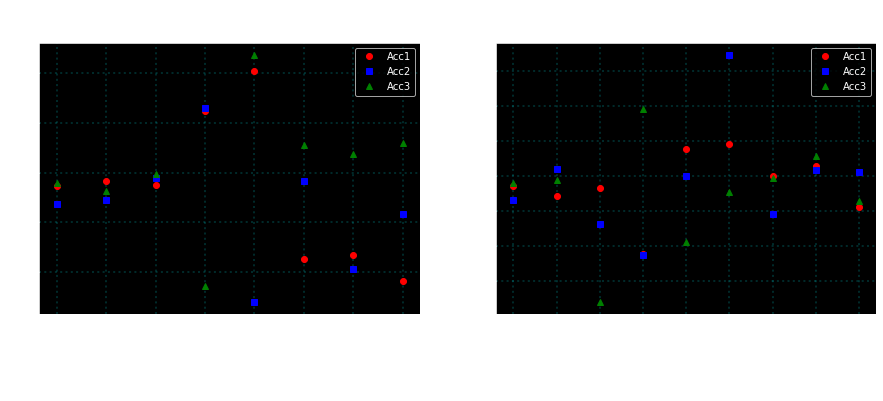

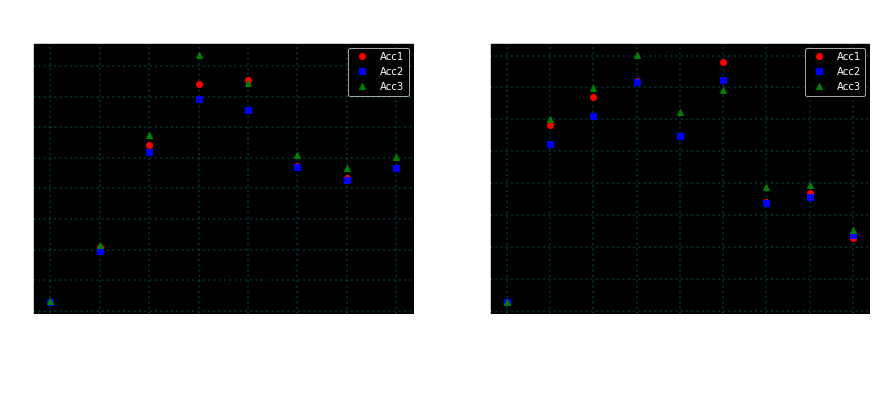

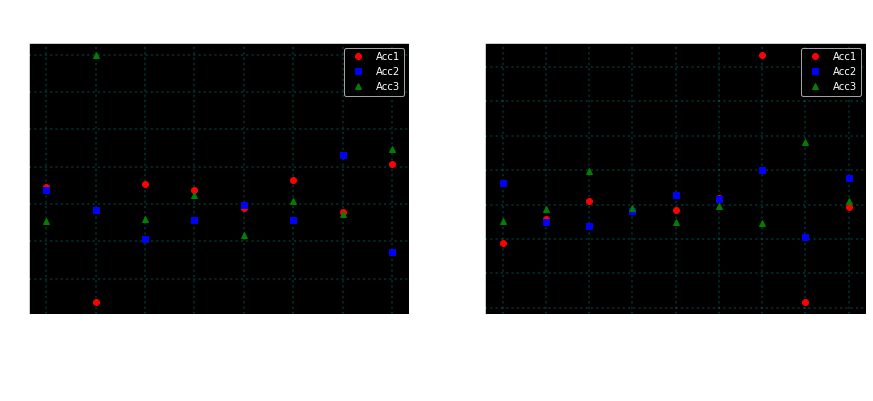

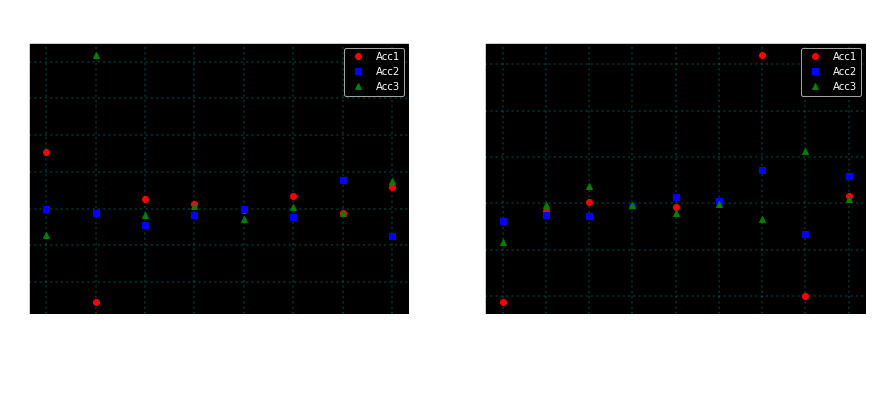

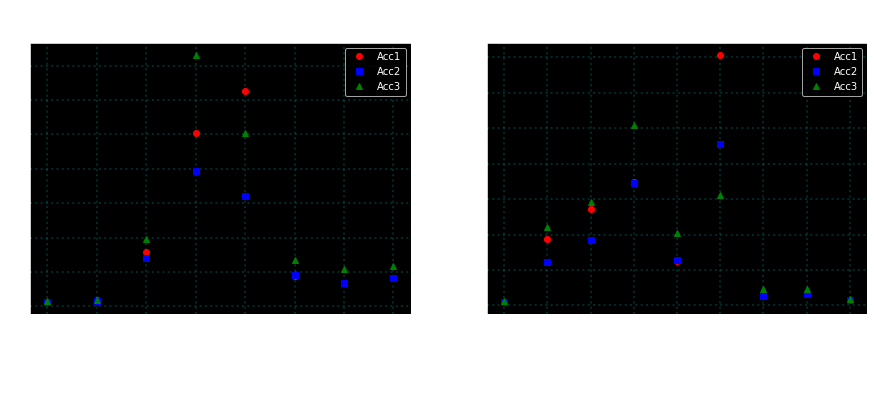

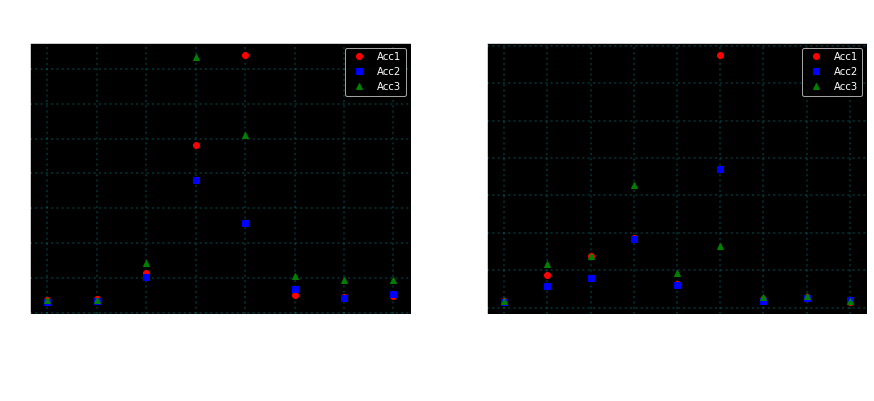

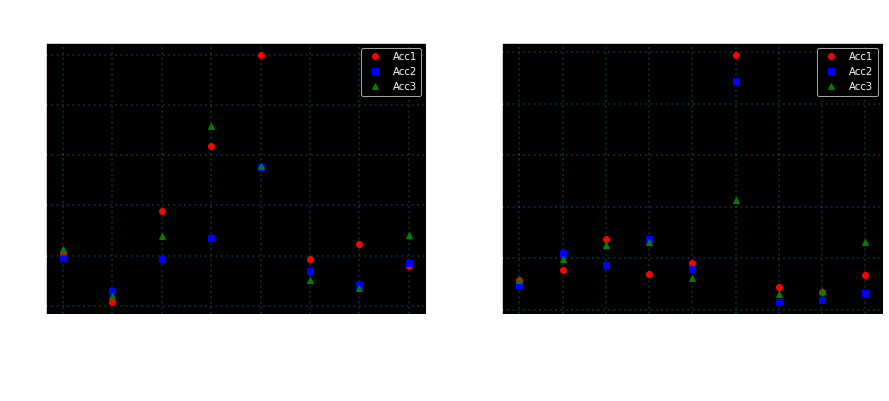

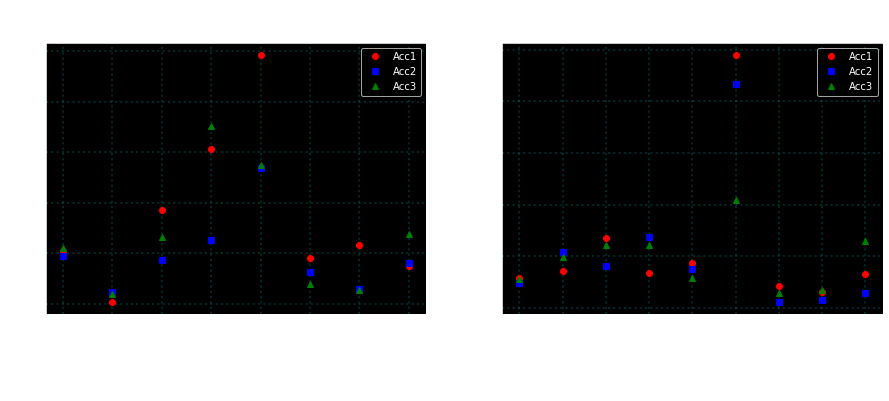

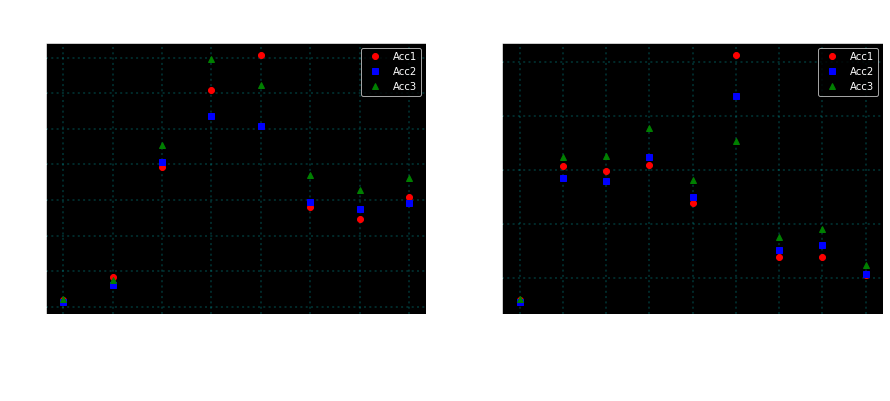

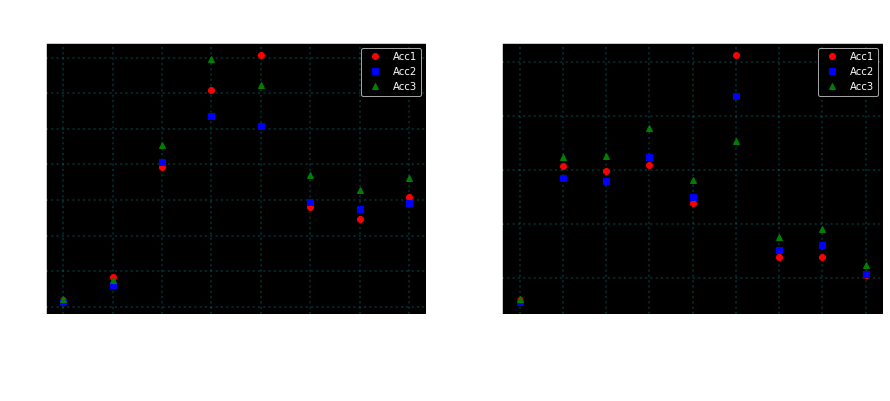

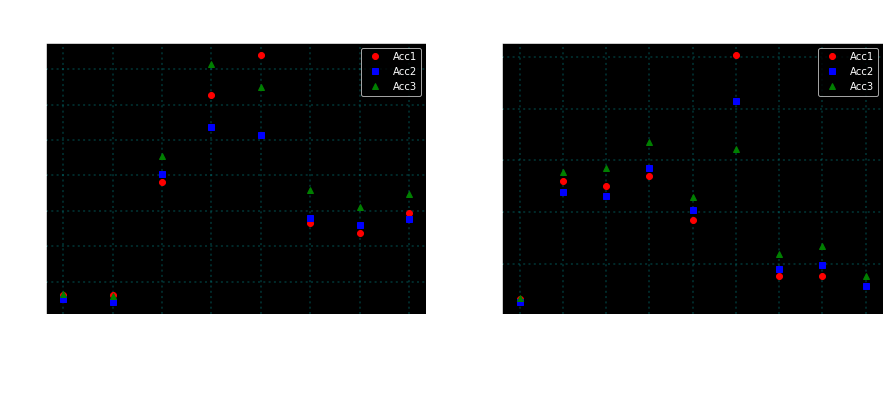

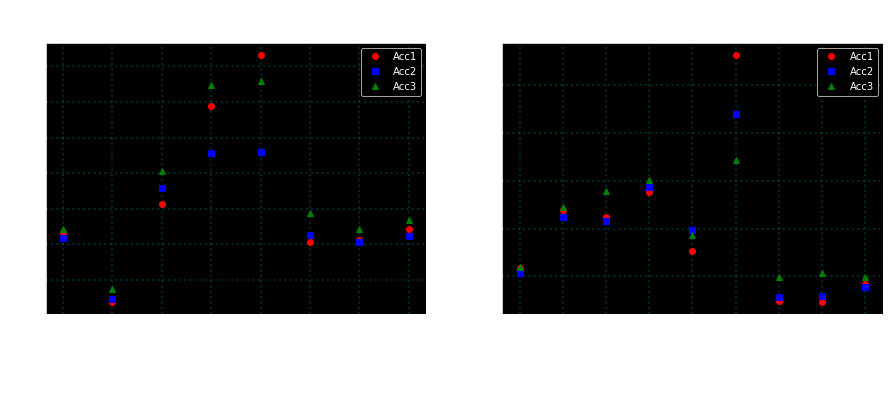

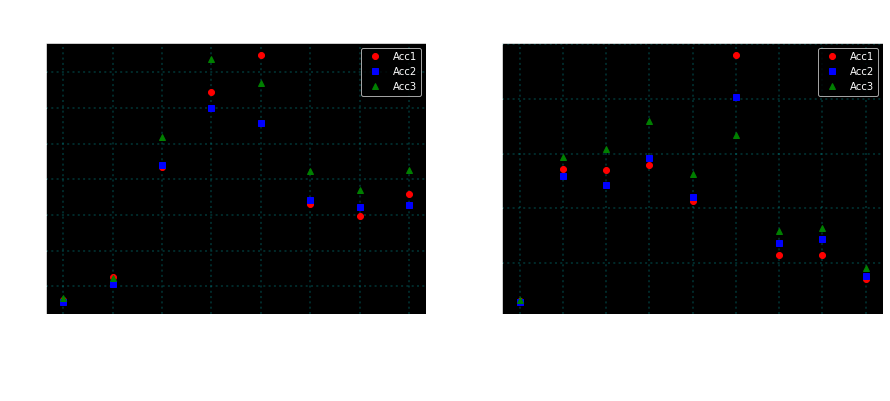

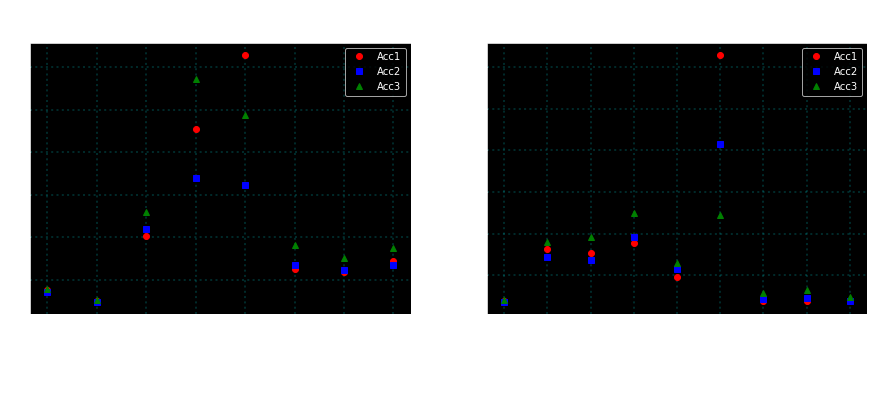

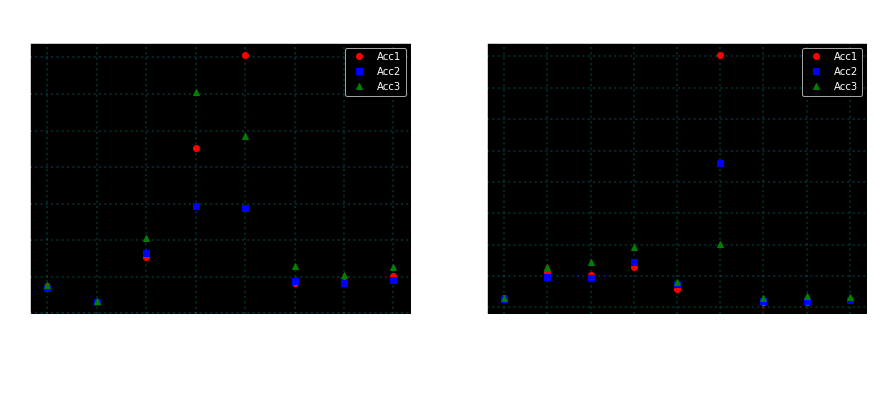

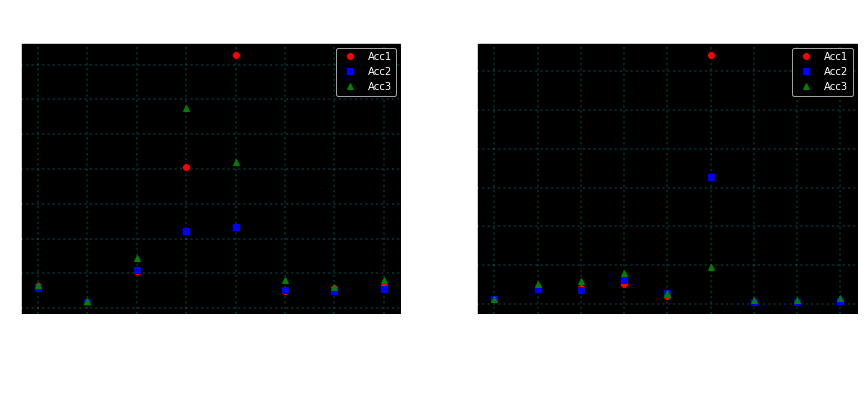

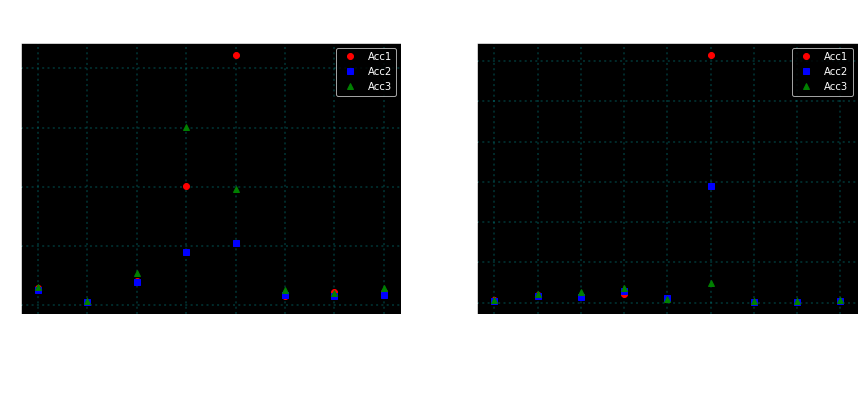

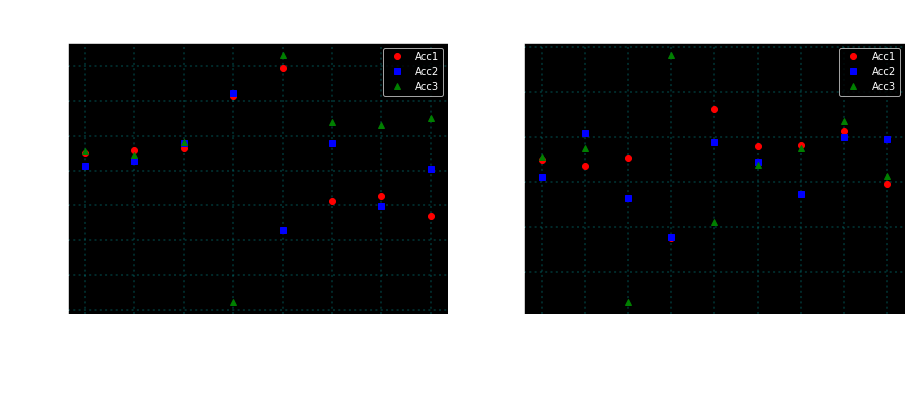

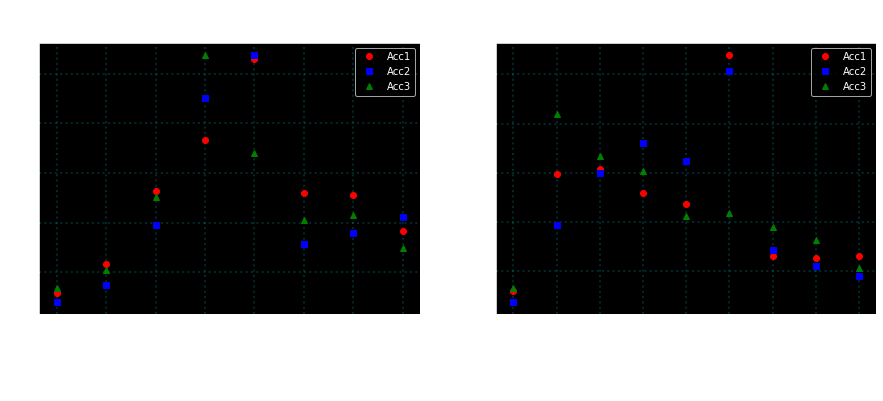

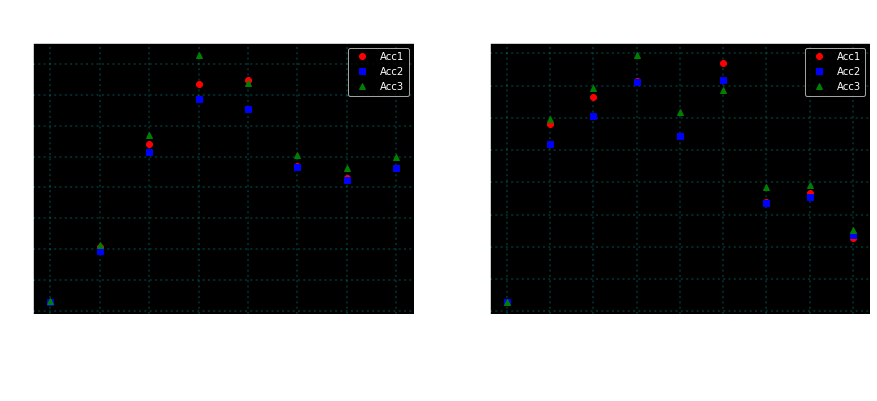

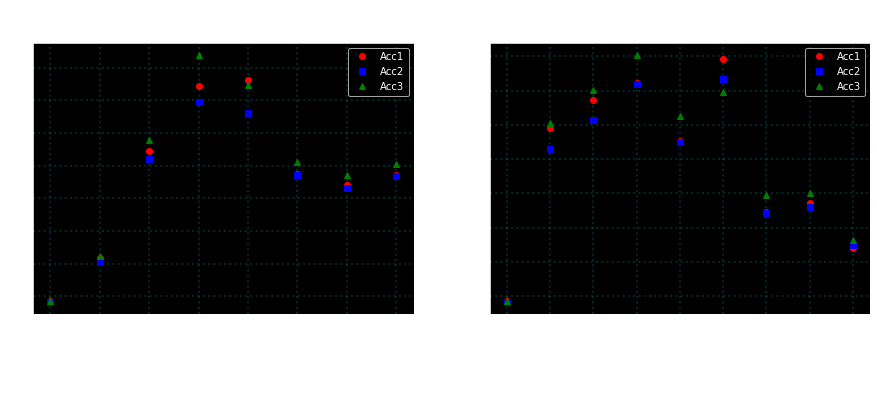

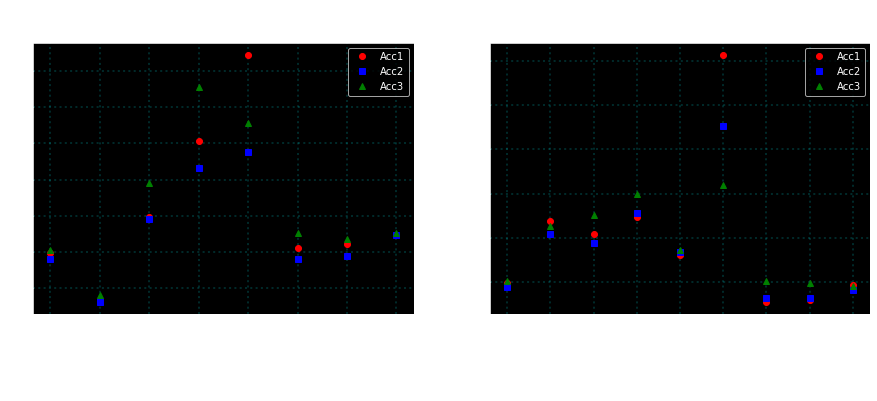

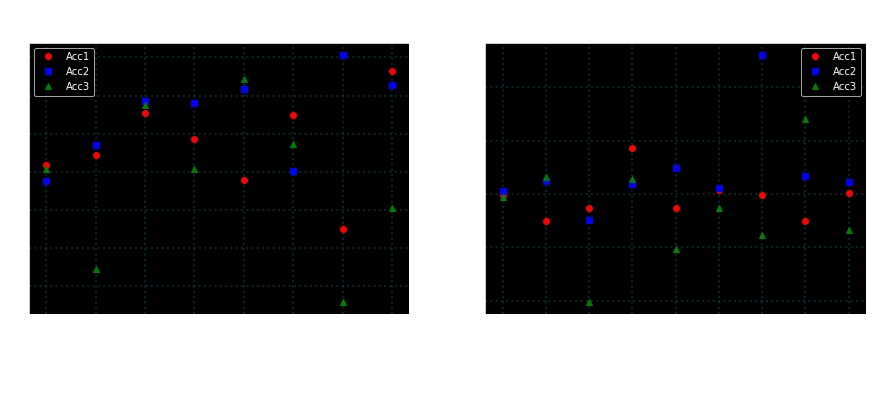

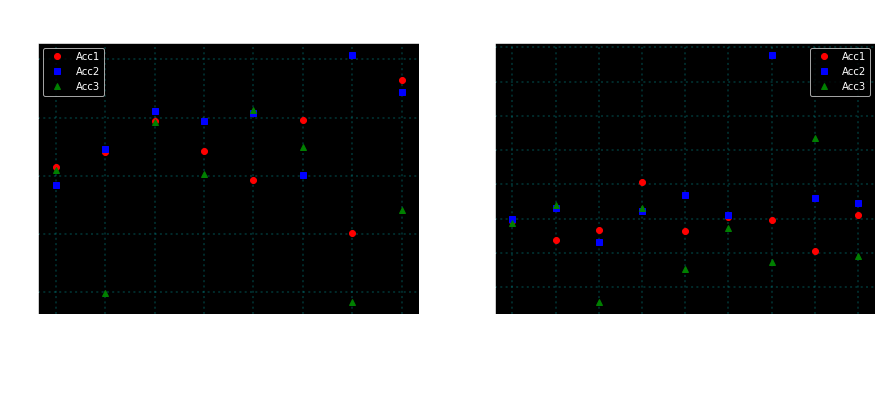

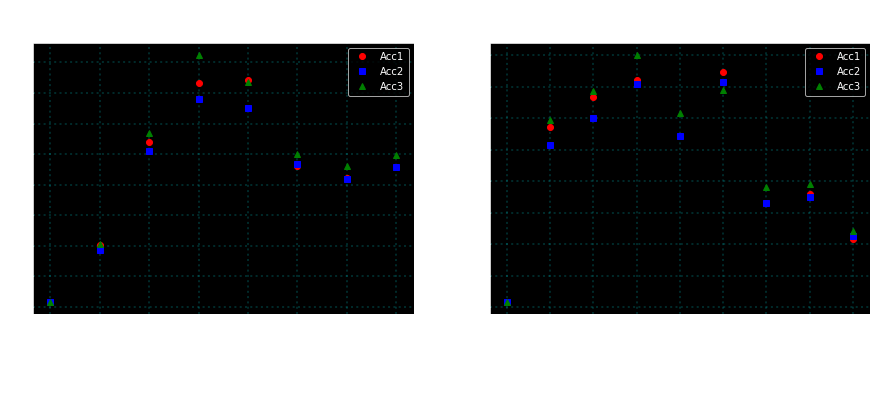

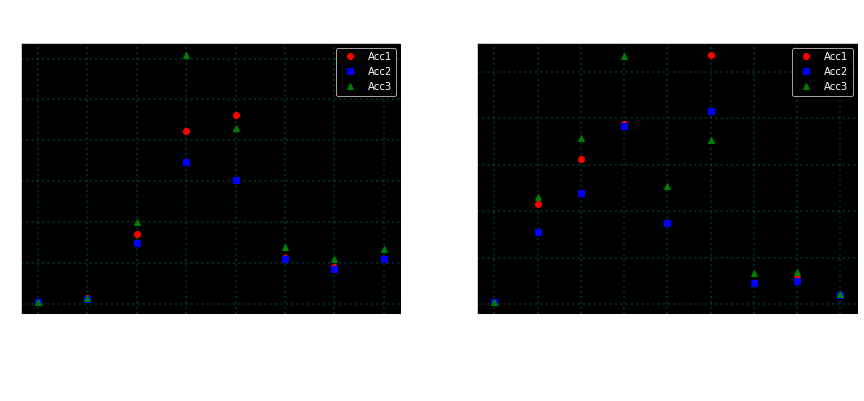

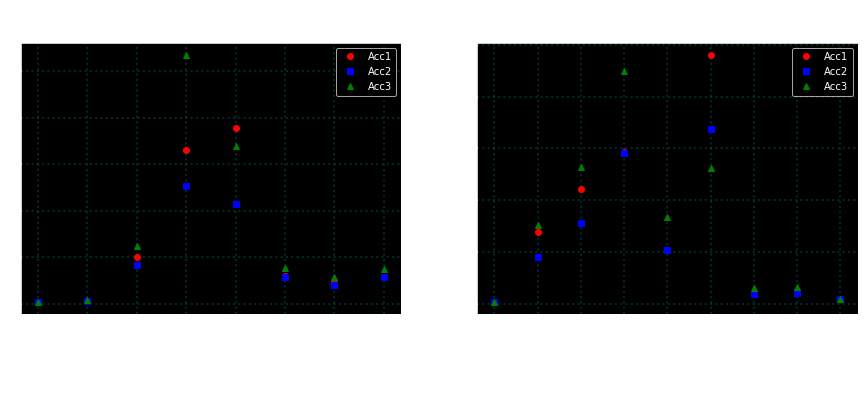

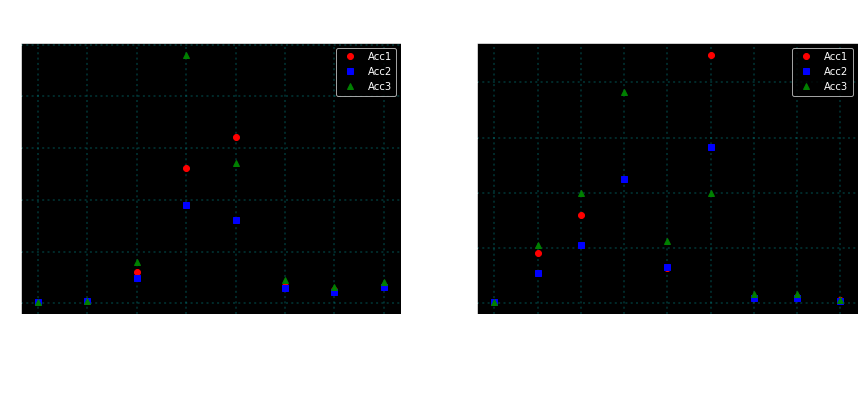

In [17]:
# Comparison between HPF enable and disable
multiPlotDataset([dataset_hpf_1, dataset_hpf_2], ["HPF Disable", "HPF Enable"])

# Comparison between with and without flowmeter
multiPlotDataset([dataset_3, dataset_4], ["With FlowMeter", "Without FlowMeter"])

# Comparison between acc data
multiPlotAcc([df_1.loc['Acc3'], df_2.loc['Acc3'], df_4.loc['Acc3']], ["Diff_Acc", "With FlowMeter", "Without FlowMeter"])